## 基础的模型：广义帕累托分布。对于99分位数以后使用重采样的结果。基本可以得到fair fit以上

适合的测序方法：(绝大部分)
- 10x Visium
- Xenium(不是很好)
- Stereo-seq
- Vsium HD(非常好)
- seqFish
- Slide-V2

并且发现，单细胞测序的方差也能使用这个模型拟合：
- 10x Genomics scRNA-seq
- 10X Multiome Gene Expression and Chromatin Accessability

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
# 读取数据
# adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")

if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算每个基因的方差（适用于普通numpy数组）
def calc_var(X, axis=0):
    # 直接使用numpy的var函数
    return np.var(X, axis=axis)

gene_variances = calc_var(adata.X)

# 设定阈值，例如使用98百分位数
threshold = np.percentile(gene_variances, 99)

# 分割数据
main_data = gene_variances[gene_variances <= threshold]
tail_data = gene_variances[gene_variances > threshold]

# 对主体部分拟合广义帕累托分布
shape, loc, scale = genpareto.fit(main_data)

# 生成新样本
n_main = len(main_data)
n_tail = len(tail_data)

# 对主体部分使用拟合的分布生成样本
new_main = genpareto.rvs(shape, loc, scale, size=n_main)

# 对尾部直接进行重抽样
new_tail = np.random.choice(tail_data, size=n_tail, replace=True)

# 合并样本
new_samples = np.concatenate([new_main, new_tail])

# 确保新样本在原始数据的范围内
new_samples = np.clip(new_samples, np.min(gene_variances), np.max(gene_variances))


## 对长尾高值部分的，直接等值。基本可以得到excellent fit的结果

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto
import scanpy as sc
import scipy.sparse as sp
# 读取数据
# adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/Sample_data_151676.h5ad")
sc.pp.filter_genes(adata, min_cells=5)

if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算每个基因的方差（适用于普通numpy数组）
def calc_var(X, axis=0):
    # 直接使用numpy的var函数
    return np.var(X, axis=axis)

gene_variances = calc_var(adata.X)

# 设定阈值，例如使用98百分位数
threshold = np.percentile(gene_variances, 99)

# 分割数据
main_data = gene_variances[gene_variances <= threshold]
tail_data = gene_variances[gene_variances > threshold]

# 对主体部分拟合广义帕累托分布
shape, loc, scale = genpareto.fit(main_data)

# 生成新样本
n_main = len(main_data)
n_tail = len(tail_data)

# 对主体部分使用拟合的分布生成样本
new_main = genpareto.rvs(shape, loc, scale, size=n_main)

# 对尾部直接进行重抽样
new_tail = tail_data
# 合并样本
new_samples = np.concatenate([new_main, new_tail])

# 确保新样本在原始数据的范围内
new_samples = np.clip(new_samples, np.min(gene_variances), np.max(gene_variances))


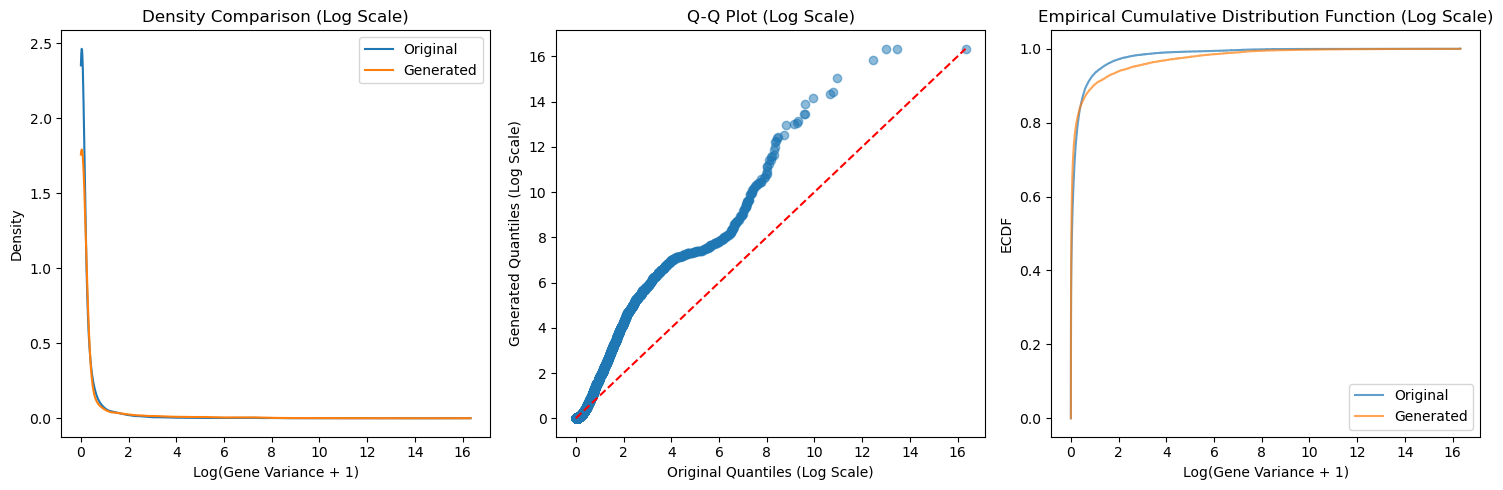

Cohen's d: -0.017649351249962482
Relative Error: 3.282390612072784
KS Statistic: 0.11426726920593933
Correlation: 0.5888183392401357
Quantile Relative Errors:
  25.0th: 0.2271
  50.0th: 0.5166
  75.0th: 0.3878
  90.0th: 0.7125
  95.0th: 3.2227
  99.0th: 19.0247
Verdict: Poor fit


In [161]:
import numpy as np
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def evaluate_fit(original, generated, quantiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]):
    def cohens_d(x1, x2):
        n1, n2 = len(x1), len(x2)
        var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
        pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
        return (np.mean(x1) - np.mean(x2)) / pooled_se

    def relative_error(x1, x2):
        return np.abs(np.mean(x1) - np.mean(x2)) / np.mean(x1)

    # 计算主要指标
    effect_size = cohens_d(original, generated)
    rel_error = relative_error(original, generated)
    ks_stat, _ = ks_2samp(original, generated)
    correlation = np.corrcoef(np.sort(original), np.sort(generated))[0, 1]

    # 计算分位数相对误差
    orig_quant = np.quantile(original, quantiles)
    gen_quant = np.quantile(generated, quantiles)
    quant_rel_errors = np.abs(orig_quant - gen_quant) / orig_quant

    # 评估结果
    results = {
        "Cohen's d": effect_size,
        "Relative Error": rel_error,
        "KS Statistic": ks_stat,
        "Correlation": correlation,
        "Quantile Relative Errors": dict(zip([f"{q*100}th" for q in quantiles], quant_rel_errors))
    }

    # 修改判定标准
    excellent = (abs(effect_size) < 0.05 and rel_error < 0.05 and ks_stat < 0.1 and correlation > 0.95
                )

    good = (abs(effect_size) < 0.1 and rel_error < 0.15 and ks_stat < 0.15 and correlation > 0.9 
            )

    fair = (abs(effect_size) < 0.2 and rel_error < 0.2 and ks_stat < 0.2 and correlation > 0.8 
            )



    if excellent:
        verdict = "Excellent fit"
    elif good:
        verdict = "Good fit"
    elif fair:
        verdict = "Fair fit"
    else:
        verdict = "Poor fit"

    results["Verdict"] = verdict

    # 可视化（使用对数刻度）
    plt.figure(figsize=(15, 5))

    # 密度图比较
    plt.subplot(131)
    kde_orig = gaussian_kde(np.log1p(original))
    kde_gen = gaussian_kde(np.log1p(generated))
    x_range = np.linspace(np.min(np.log1p(original)), np.max(np.log1p(original)), 1000)
    plt.plot(x_range, kde_orig(x_range), label='Original')
    plt.plot(x_range, kde_gen(x_range), label='Generated')
    plt.title('Density Comparison (Log Scale)')
    plt.xlabel('Log(Gene Variance + 1)')
    plt.ylabel('Density')
    plt.legend()

    # Q-Q图（对数刻度）
    plt.subplot(132)
    plt.scatter(np.log1p(np.sort(original)), np.log1p(np.sort(generated)), alpha=0.5)
    plt.plot([np.log1p(min(original)), np.log1p(max(original))], 
             [np.log1p(min(original)), np.log1p(max(original))], 'r--')
    plt.xlabel('Original Quantiles (Log Scale)')
    plt.ylabel('Generated Quantiles (Log Scale)')
    plt.title('Q-Q Plot (Log Scale)')

    # ECDF（对数刻度）
    plt.subplot(133)
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(data)+1) / len(data)
        return x, y
    x_orig, y_orig = ecdf(original)
    x_gen, y_gen = ecdf(generated)
    plt.step(np.log1p(x_orig), y_orig, where='post', label='Original', alpha=0.7)
    plt.step(np.log1p(x_gen), y_gen, where='post', label='Generated', alpha=0.7)
    plt.xlabel('Log(Gene Variance + 1)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function (Log Scale)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

# 使用函数
evaluation = evaluate_fit(gene_variances, new_samples)

# 打印结果
for key, value in evaluation.items():
    if isinstance(value, dict):
        print(f"{key}:")
        for subkey, subvalue in value.items():
            print(f"  {subkey}: {subvalue:.4f}")
    else:
        print(f"{key}: {value}")

## 第二个特殊的混合模型：对数正态分布
比如Merfish等，并没有很多dropout的结果，不适合用广义帕累托分布进行拟合。反而，使用对数正态分布效果很好

适合的模型：
- Merfish
- 

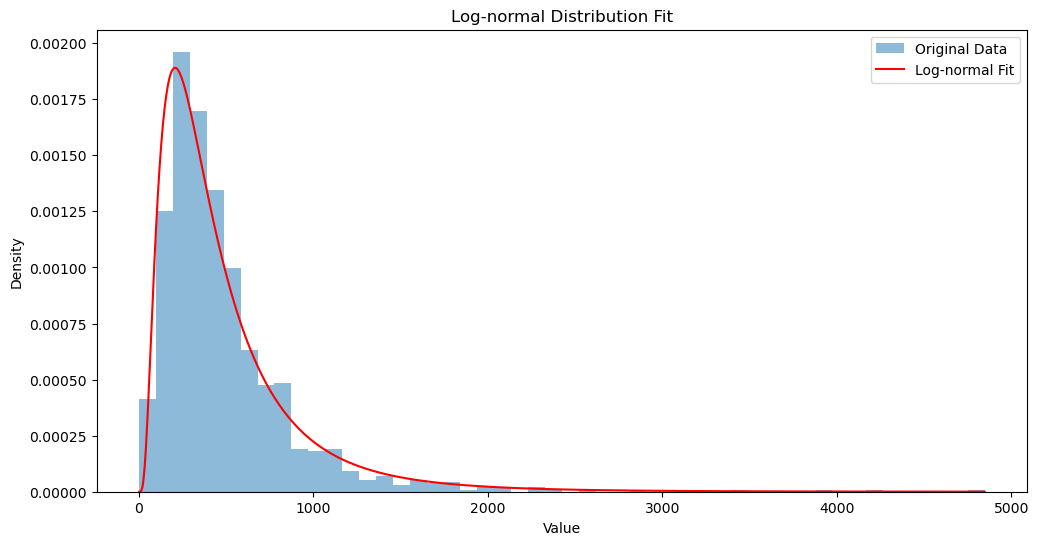

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import scanpy as sc
import scipy.sparse as sp

def calc_var(X, axis=0):
    return np.var(X, axis=axis)

def fit_lognormal(data):
    log_data = np.log(data)
    mu = np.mean(log_data)
    sigma = np.std(log_data)
    return sigma, 0, np.exp(mu)

def generate_lognormal_samples(params, n_samples):
    sigma, loc, scale = params
    return lognorm.rvs(s=sigma, loc=loc, scale=scale, size=n_samples)

def plot_distribution(data, params):
    plt.figure(figsize=(12, 6))
    
    # 绘制原始数据直方图
    plt.hist(data, bins=50, density=True, alpha=0.5, label='Original Data')
    
    # 生成用于绘制的x值
    x = np.linspace(min(data), max(data), 1000)
    
    # 绘制对数正态分布曲线
    sigma, loc, scale = params
    y_lognorm = lognorm.pdf(x, s=sigma, scale=scale)
    plt.plot(x, y_lognorm, 'r-', label='Log-normal Fit')
    
    plt.legend()
    plt.title('Log-normal Distribution Fit')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

# # 读取数据
adata = sc.read("/Users/chen_yiru/Desktop/simulation/data/raw/merfish_adata.h5ad")
# 如果adata.X是稀疏矩阵，请转换为密集矩阵
if sp.issparse(adata.X):
    adata.X = adata.X.A
# 计算基因方差
gene_variances = calc_var(adata.X)

# 拟合对数正态分布
lognormal_params = fit_lognormal(gene_variances)

# 生成样本
lognormal_samples = generate_lognormal_samples(lognormal_params, n_samples=1000)

# 可视化对数正态分布拟合
plot_distribution(gene_variances, lognormal_params)


# 测试单细胞测序

In [145]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

# Data retrieval
import pooch

In [146]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [148]:
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

sample
s1d1    8785
Name: count, dtype: int64


/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/chen_yiru/miniconda3/envs/simulation/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8785 × 36601
    obs: 'sample'

In [149]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [150]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [159]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [153]:
adata.X

<8713x21675 sparse matrix of type '<class 'numpy.float32'>'
	with 14066479 stored elements in Compressed Sparse Row format>

In [124]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [125]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()